 # Prediction
 Keras on Tensorflow
 
 This prediction runs on all 9 dataset. 

In [1]:
import os, sys
import cv2
import numpy as np
import uuid
import tensorflow as tf
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from imutils import paths
import itertools
import json
from pprint import pprint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.models import UNet
from core.metrics import iou_coef, dice_coef


from tensorflow.keras.models import load_model
from datetime import datetime

from core.imageprep import create_crop_idx, crop_to_patch, construct_from_patch, create_crop_idx_whole
from core.train_predict import stack_predict, stack_predict_v2
from tqdm.notebook import trange

from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('load_ext', 'tensorboard')

In [2]:
from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


 ## Load Training Dataset

In [3]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# experiment
exp_name = 'dl_seg_project_raw'

# label
label = 'cell_membrane'

# trianing timestamp
training_date = '2019_12_06'
imginput_timestamp = '2019_12_06_17_06'
# model_training_timestamp = '2019_12_11_12_21'
model_training_timestamp = '2019_12_06_17_14'
print('Training timestamp: {}'.format(model_training_timestamp))

# input img path
imginput = os.path.join(exp_name, 'data_crop', imginput_timestamp)
imgpath = os.path.join(path, imginput)
print('Input Images Path: {}'.format(imgpath))

# model path
modelfd = 'model'
modelfn = 'model_' + model_training_timestamp + '.h5'
path_model = os.path.join(path, 'logs', modelfd, label, training_date, modelfn)
print('Model Path: {}'.format(path_model))

# raw path
rawfd = 'raw_input_image'
path_raw = os.path.join(path, rawfd)
print('Raw Path: {}'.format(path_raw))

# prediction path
pred_path = os.path.join(path, exp_name)
dir_checker('pred_img', pred_path)

Load Images...
Training timestamp: 2019_12_06_17_14
Input Images Path: D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_06_17_06
Model Path: D:PerlmutterData\logs\model\cell_membrane\2019_12_06\model_2019_12_06_17_14.h5
Raw Path: D:PerlmutterData\raw_input_image
pred_img exists in D:PerlmutterData\dl_seg_project_raw


## Parameter

In [4]:
# load parameter
parsfd = 'pars'
parsfn = 'pars_' + model_training_timestamp + '.json'
path_pars = os.path.join(path, 'logs', parsfd, label, training_date, parsfn)

with open(path_pars) as json_file:
    pars = json.load(json_file)

In [5]:
pprint(pars)

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 16,
 'classes': ['cell_membrane', 'nucleus', 'autophagosome'],
 'data_gen_img_args': {'height_shift_range': 0.1,
                       'horizontal_flip': True,
                       'rescale': 0.00392156862745098,
                       'rotation_range': 90.0,
                       'shear_range': 0.07,
                       'validation_split': 0.1,
                       'vertical_flip': True,
                       'width_shift_range': 0.1,
                       'zoom_range': 0.2},
 'data_gen_label_args': {'height_shift_range': 0.1,
                         'horizontal_flip': True,
                         'rescale': 0.00392156862745098,
                         'rotation_range': 90.0,
                         'shear_range': 0.07,
                         'validation_split': 0.1,
                         'vertical_flip': True,
                         'width_shift_range': 0.1,
                         'zoom_range': 0.2},
 'epo

In [6]:
label = pars['inputclass']
IMG_HEIGHT = pars['IMG_HEIGHT']
IMG_WIDTH = pars['IMG_WIDTH']

IMG_HEIGHT = 256
IMG_WIDTH = 256

## Predict from Testing Dataset

In [7]:
# get dataset
rawfdlist = os.listdir(path_raw)
rawfdlist = rawfdlist[:3]
# rawfdlist = list(rawfdlist[i] for i in [1])
print(rawfdlist)

['data_d00_batch01_loc01', 'data_d00_batch02_loc02', 'data_d00_batch02_loc03']


In [8]:
rawimglist = {}
for folder in rawfdlist:
    print(folder)
    rawimglist[folder] = list(paths.list_images(os.path.join(path_raw, folder, 'image')))

data_d00_batch01_loc01
data_d00_batch02_loc02
data_d00_batch02_loc03


In [9]:
pprint(rawimglist)

{'data_d00_batch01_loc01': ['D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0001.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0002.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0003.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0004.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0005.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0006.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0007.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-

                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_0037.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_0038.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_0039.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_0040.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_0041.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_0042.tif',
                            'D:PerlmutterData\

                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_1211.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_1212.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_1213.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_1214.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_1215.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc02\\image\\TH-4891 '
                            '0day DOX D-K8_1216.tif',
                            'D:PerlmutterData\

                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc03\\image\\TH-4891 '
                            '0day DOX D A12 2nd time_0386.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc03\\image\\TH-4891 '
                            '0day DOX D A12 2nd time_0387.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc03\\image\\TH-4891 '
                            '0day DOX D A12 2nd time_0388.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc03\\image\\TH-4891 '
                            '0day DOX D A12 2nd time_0389.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc03\\image\\TH-4891 '
                            '0day DOX D A12 2nd time_0390.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch02_loc03\\image\\TH-4891 '
                            '0day DOX D A12 2nd ti

## Define Prediction Set 

In [10]:
samplesize = 10
rawimglist_small = {}
for idx, item in rawimglist.items():
    rawimglist_small[idx] = rawimglist[idx][:samplesize]
# pprint(rawimglist_small)

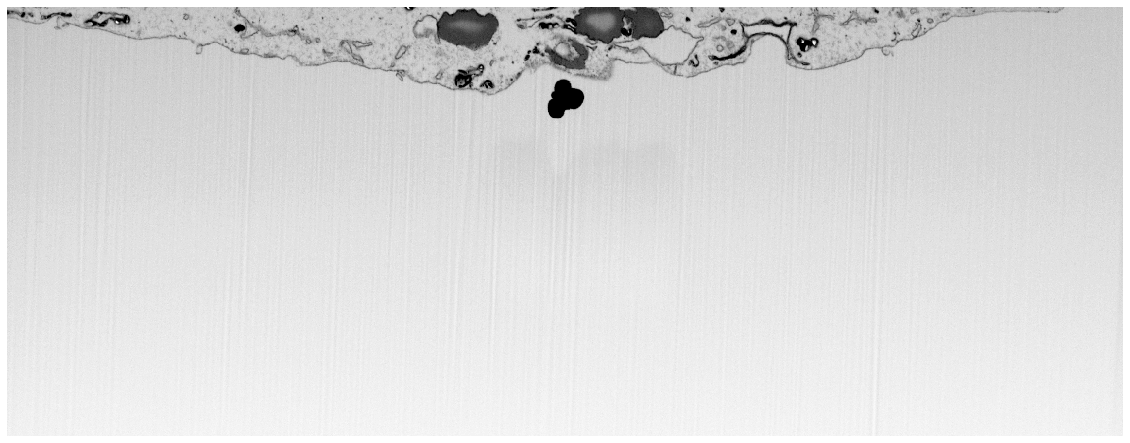

In [11]:
img = imread(rawimglist[rawfdlist[0]][0])
plt.figure(figsize = (20,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [12]:
'''
model = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})
print(model)
'''

"\nmodel = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})\nprint(model)\n"

In [13]:
img_tmp = img * 1./255.
print(img_tmp.shape)

(883, 2297)


In [14]:
learning_rate = 1e-5
loss = "binary_crossentropy"
metrics = ['accuracy', iou_coef, dice_coef]

model = UNet(shape = (None, None), 
             lr = learning_rate, 
             loss = loss,
             metrics = metrics,)

model.load_weights(path_model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [15]:
label = pars['inputclass'][0]
opdir = os.path.join(pred_path, 'pred_img')
fdnm_small = 'batch_small_fullsize'

def checkpredfolder(rawfdlist, opdir, opfolder, label):
    # folder name
    dir_checker(label, opdir)
    img_path_small = os.path.join(opdir, label)
    dir_checker(opfolder, img_path_small)

    # create folder list
    for folder in rawfdlist:
        dir_checker(folder, os.path.join(img_path_small, opfolder))

checkpredfolder(rawfdlist, opdir, fdnm_small, label)


cell_membrane exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_small_fullsize exists in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane
data_d00_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane\batch_small_fullsize
data_d00_batch02_loc02 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane\batch_small_fullsize
data_d00_batch02_loc03 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane\batch_small_fullsize


In [16]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist_small[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_small, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)

[[   0  256 2041 2297    0    9]
 [ 230  486 2041 2297    1    9]
 [ 460  716 2041 2297    2    9]
 [ 627  883    0  256    3    0]
 [ 627  883  230  486    3    1]
 [ 627  883  460  716    3    2]
 [ 627  883  690  946    3    3]
 [ 627  883  920 1176    3    4]
 [ 627  883 1150 1406    3    5]
 [ 627  883 1380 1636    3    6]
 [ 627  883 1610 1866    3    7]
 [ 627  883 1840 2096    3    8]
 [ 627  883 2041 2297    3    9]]


C:\Users\wucci_admin\Documents\code\dl_fibem_seg\core\imageprep.py:554: RuntimeWarning: Mean of empty slice
  outputimg = np.nanmean(img_stack_repos, axis = 0)
C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



[[   0  256 1523 1779    0    7]
 [ 230  486 1523 1779    1    7]
 [ 449  705    0  256    2    0]
 [ 449  705  230  486    2    1]
 [ 449  705  460  716    2    2]
 [ 449  705  690  946    2    3]
 [ 449  705  920 1176    2    4]
 [ 449  705 1150 1406    2    5]
 [ 449  705 1380 1636    2    6]
 [ 449  705 1523 1779    2    7]]



[[   0  256 1654 1910    0    8]
 [ 230  486 1654 1910    1    8]
 [ 255  511    0  256    2    0]
 [ 255  511  230  486    2    1]
 [ 255  511  460  716    2    2]
 [ 255  511  690  946    2    3]
 [ 255  511  920 1176    2    4]
 [ 255  511 1150 1406    2    5]
 [ 255  511 1380 1636    2    6]
 [ 255  511 1610 1866    2    7]
 [ 255  511 1654 1910    2    8]]


## Prediction Small Dataset with tiles
### Create Folder 

## Prediction Small Dataset with tiles (whole stack)
### Create Folder 

In [17]:
# folder name
fdnm_total = 'batch_total_fullsize'
checkpredfolder(rawfdlist, opdir, fdnm_total, label)

cell_membrane exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_total_fullsize exists in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane
data_d00_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane\batch_total_fullsize
data_d00_batch02_loc02 exists in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane\batch_total_fullsize
data_d00_batch02_loc03 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\cell_membrane\batch_total_fullsize


### Tiling Prediction with Stack Input
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [ ]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_total, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)


[[   0  256 2041 2297    0    9]
 [ 230  486 2041 2297    1    9]
 [ 460  716 2041 2297    2    9]
 [ 627  883    0  256    3    0]
 [ 627  883  230  486    3    1]
 [ 627  883  460  716    3    2]
 [ 627  883  690  946    3    3]
 [ 627  883  920 1176    3    4]
 [ 627  883 1150 1406    3    5]
 [ 627  883 1380 1636    3    6]
 [ 627  883 1610 1866    3    7]
 [ 627  883 1840 2096    3    8]
 [ 627  883 2041 2297    3    9]]
